[I 2025-10-28 17:39:16,040] A new study created in memory with name: no-name-bfd7fb15-87e2-4aee-bdd8-044b0fa5f8a1


=== Bitcoin IMPLIED Volatility (IV) Prediction Research Model ===
Loading and preprocessing data...
Dataset shape: (1585, 22)
Target (IV) statistics - Mean: -0.0265, Std: 2.6674
Data range verified: 2021-03-24 to 2025-07-25

=== Part 2: Advanced Feature Engineering ===
Generating CWT features...
Creating macro features...
Macro features created successfully
Final dataset shape: (1536, 43)
Removed 6 highly correlated features (corr > 0.95)
Remaining features: 37

=== Part 3: Model Training ===
Train set: (1228, 37), Test set: (308, 37)
Train period: 2021-05-12 to 2024-09-20
Test period: 2024-09-21 to 2025-07-25
Running hyperparameter optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-28 17:39:22,495] Trial 0 finished with value: 2.420271995254325 and parameters: {'n_estimators': 500, 'learning_rate': 0.009238511108696666, 'max_depth': 8, 'subsample': 0.9934330641894018, 'colsample_bytree': 0.7848774311891054, 'min_child_weight': 5.7155415292252085, 'gamma': 3.1756790998211777, 'reg_lambda': 2.028323595746817, 'reg_alpha': 0.5208490963890211}. Best is trial 0 with value: 2.420271995254325.
[I 2025-10-28 17:39:24,566] Trial 1 finished with value: 2.4142675232291477 and parameters: {'n_estimators': 1200, 'learning_rate': 0.06208756027244306, 'max_depth': 7, 'subsample': 0.995651579724798, 'colsample_bytree': 0.9860843608839496, 'min_child_weight': 6.708522127863727, 'gamma': 0.879354067558854, 'reg_lambda': 0.0757163559398677, 'reg_alpha': 2.9647613195665468}. Best is trial 1 with value: 2.4142675232291477.
[I 2025-10-28 17:39:28,404] Trial 2 finished with value: 2.3671080659721033 and parameters: {'n_estimators': 1100, 'learning_rate': 0.02163394223699302,

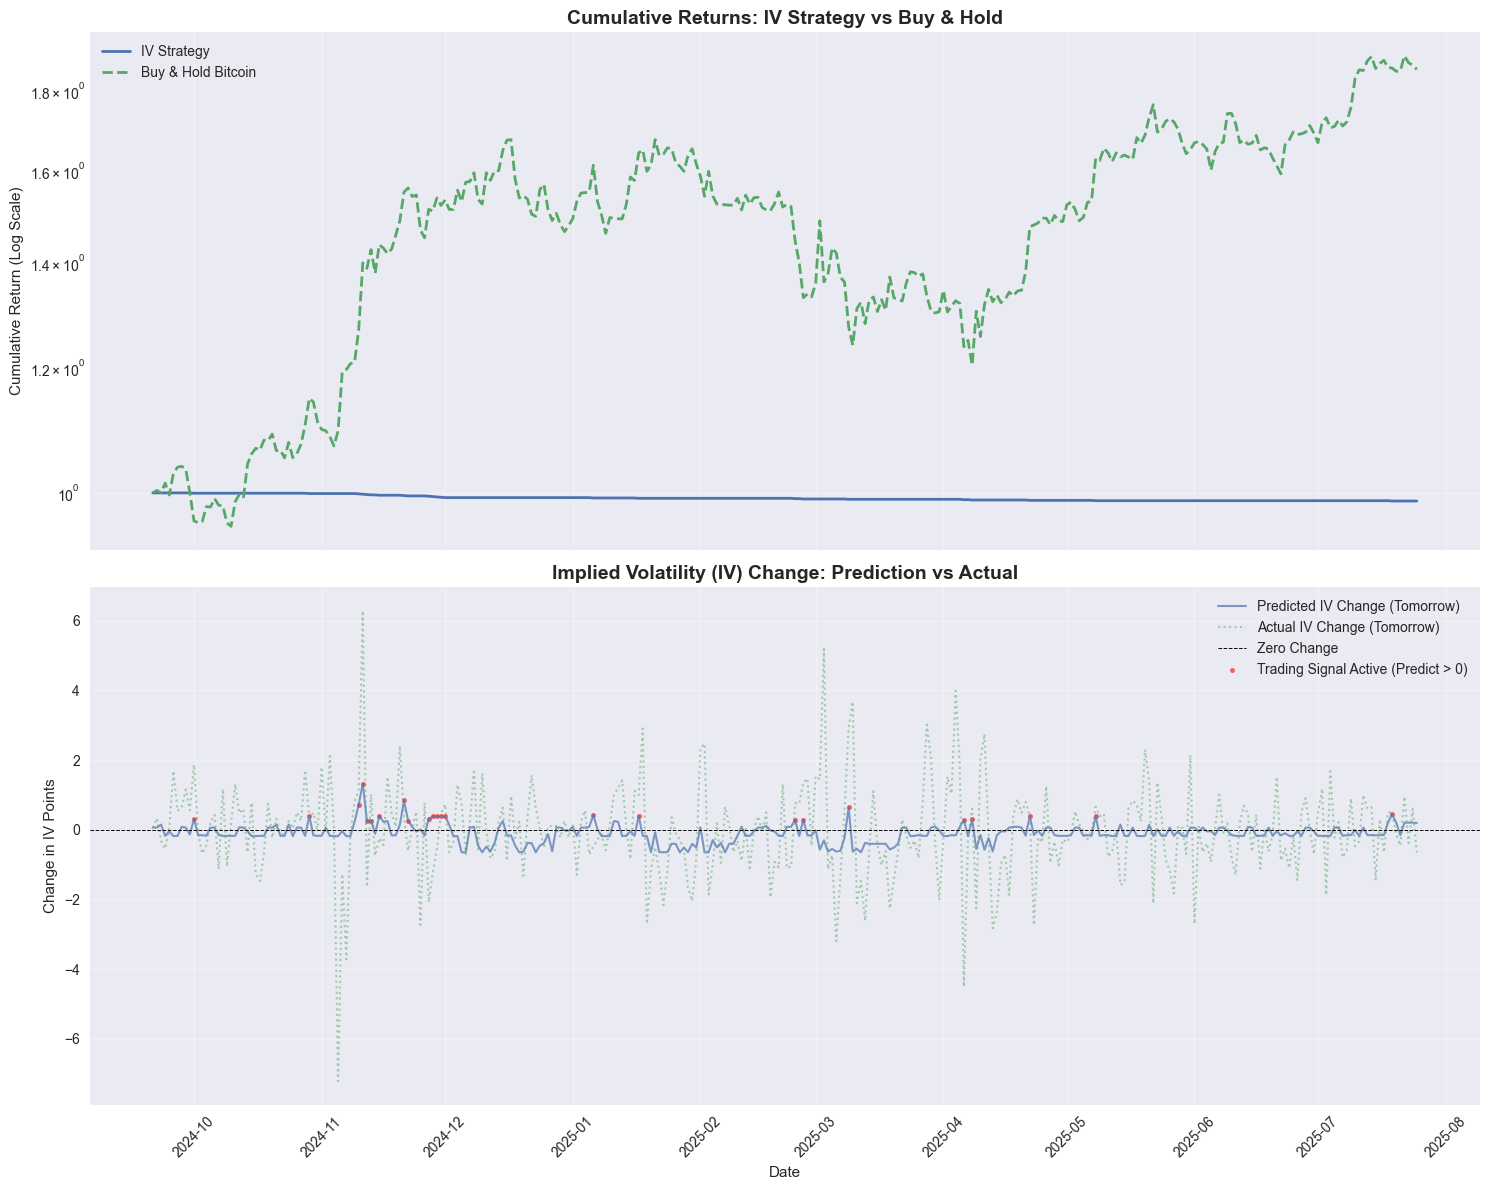

Generating SHAP explanations...


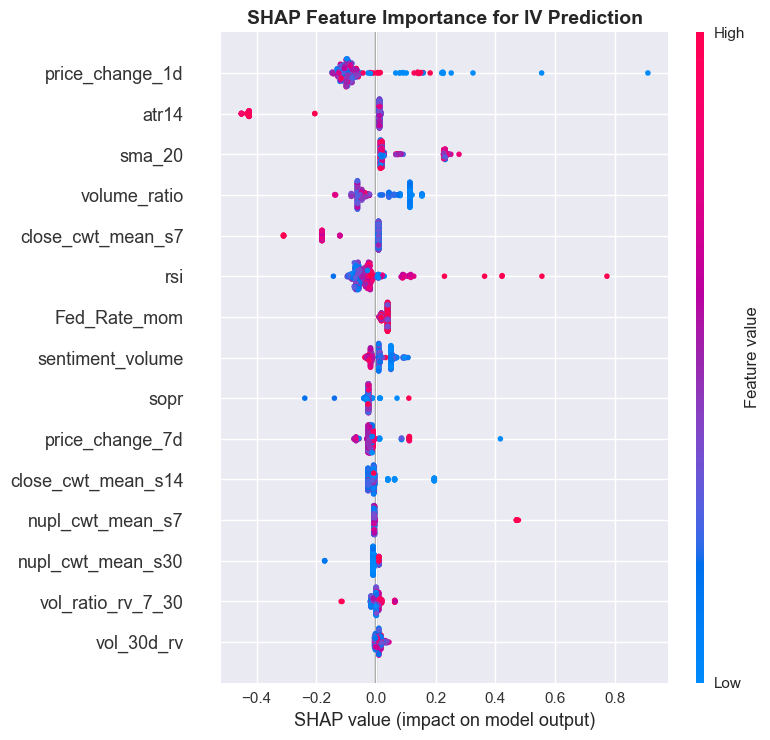

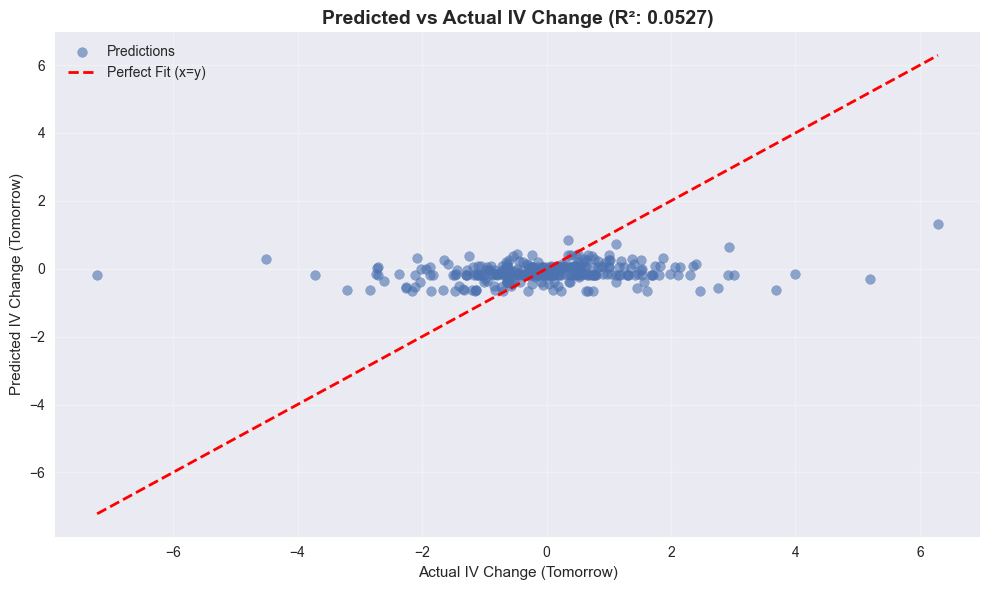

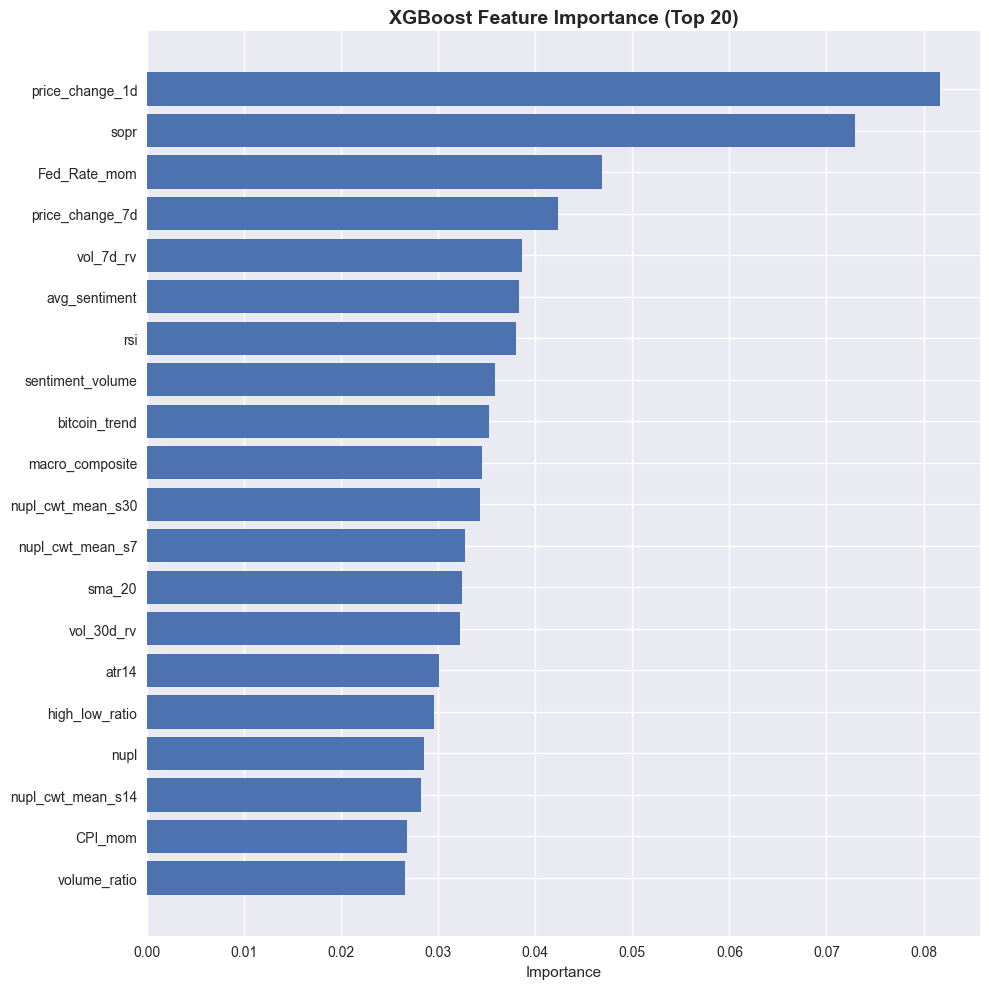


RESEARCH SUMMARY (IMPLIED VOLATILITY PIVOT)
✅ Target: 1-Day Future *Change* in Implied Volatility (DVOL)
✅ Data: Verified from 2021-05-12 to 2025-07-25
✅ Model: XGBoost Regressor (RMSE: 1.2943, R²: 0.0527)
✅ Features: 37 (CWT, Macro, On-Chain, RV/IV Premium)
✅ Economic Value: Strategy Sharpe Ratio = -13.40
✅ Benchmark Value: Buy & Hold Sharpe Ratio = 1.78

Trading Strategy:
• Logic: Go 'long volatility' if predicted IV CHANGE > 0.0
• PnL: Based on stable, normalized change in actual IV points
• Costs: 0.050% per trade signal
• Performance: -1.40% annualized return
• Risk-Adjusted: Sharpe -13.40 vs B&H Sharpe 1.78

RESEARCH INSIGHTS

Top 5 Most Important Features:
  price_change_1d (0.0817)
  sopr (0.0729)
  Fed_Rate_mom (0.0469)
  price_change_7d (0.0423)
  vol_7d_rv (0.0387)

Strategy Performance Analysis:
Win Rate (days): 0.00%
Average Win: nan (normalized return)
Average Loss: -0.0005 (normalized return)
Profit Factor: nan

Model successfully tests a rigorous IV prediction hypothes

In [ ]:
"""
Reproducibility Note
-------------------
Minor formatting changes (e.g., removal of emojis in console print statements and
comment cleanup) were made for academic presentation clarity. These changes do
not affect model estimation, predictions, or reported results.

Earlier exploratory runs printed informal diagnostic markers (e.g., "goal: be positive")
in the console output. These were removed in the shared script for academic clarity.
Model specification, data, and results are unchanged.
"""


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import sys
import shap
import pywt
from xgboost import XGBRegressor
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# --- CONFIGURATION ---
DATA_FILE_PATH = r"merged_data_with_iv.csv"
LAST_REAL_DATA_DATE = '2025-07-26' # last available data point
VOLATILITY_THRESHOLD = 0.0 
TRANSACTION_COST = 0.0005 # 0.05% cost per trade
# --- END CONFIGURATION ---

# plot style for publication-ready plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("=== Bitcoin IMPLIED Volatility (IV) Prediction Research Model ===")
print("Loading and preprocessing data...")

# Part 1: Data Loading and Target Variable Transformation
def load_and_preprocess_data(data_path, max_date_str):
    """Load merged IV data and create the new IV target variable"""
    df = pd.read_csv(data_path, parse_dates=['date'])
    
    #  truncate the data to the last known real date
    df = df[df['date'] <= pd.to_datetime(max_date_str)].copy()
    
    
    #  predicting TOMORROW'S Implied Volatility (IV)
    # 'iv' is the DVOL index 
    df['target'] = df['iv'].shift(-1) - df['iv']
    
    # using current Realized Volatility as a feature
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
    df['current_rv_30d'] = df['log_ret'].rolling(30).std() * np.sqrt(365) # RV (past)
    
    # Removing rows where target is NaN (end of dataset)
    df = df.dropna(subset=['target'])
    
    print(f"Dataset shape: {df.shape}")
    print(f"Target (IV) statistics - Mean: {df['target'].mean():.4f}, Std: {df['target'].std():.4f}")
    print(f"Data range verified: {df['date'].min().date()} to {df['date'].max().date()}")
    
    return df

df = load_and_preprocess_data(DATA_FILE_PATH, LAST_REAL_DATA_DATE)


# Part 2: Advanced Feature Engineering
print("\n=== Part 2: Advanced Feature Engineering ===")

def create_wavelet_features(df, column, scales=[7, 14, 30], wavelet='morl'):
    """Create CWT features for time series analysis."""
    series = df[column].values
    wavelet_features = {}
    
    for scale in scales:
        try:
            coefficients, frequencies = pywt.cwt(series, scale, wavelet)
            abs_coeff = np.abs(coefficients)
            wavelet_features[f'{column}_cwt_mean_s{scale}'] = np.mean(abs_coeff, axis=0)[:len(series)]
            wavelet_features[f'{column}_cwt_std_s{scale}'] = np.std(abs_coeff, axis=0)[:len(series)]
        except Exception as e:
            print(f"Warning: Could not create CWT for {column} at scale {scale}: {e}")
            wavelet_features[f'{column}_cwt_mean_s{scale}'] = np.zeros(len(series))
            wavelet_features[f'{column}_cwt_std_s{scale}'] = np.zeros(len(series))
    
    return wavelet_features

def create_macro_features(df):
    """Create macro features accounting for monthly data structure."""
    print("Creating macro features...")
    df['CPI_lag_30'] = df['CPI'].shift(30)
    df['Fed_Rate_lag_30'] = df['Fed_Rate'].shift(30)
    df['DXY_lag_30'] = df['DXY'].shift(30)
    
    df['CPI_mom'] = df['CPI'].diff(30)
    df['Fed_Rate_mom'] = df['Fed_Rate'].diff(30)
    df['DXY_mom'] = df['DXY'].diff(30)
    
    df['macro_composite'] = (
        df['CPI_lag_30'].fillna(method='ffill') + 
        df['Fed_Rate_lag_30'].fillna(method='ffill') + 
        df['DXY_lag_30'].fillna(method='ffill')
    ) / 3
    
    print("Macro features created successfully")
    return df

def engineer_features(df):
    """Create the complete feature set for IV prediction"""
    
    print("Generating CWT features...")
    close_wavelet = create_wavelet_features(df, 'close', scales=[7, 14, 30])
    nupl_wavelet = create_wavelet_features(df, 'nupl', scales=[7, 14, 30])
    
    for feature_name, values in close_wavelet.items(): df[feature_name] = values
    for feature_name, values in nupl_wavelet.items(): df[feature_name] = values
    
    df = create_macro_features(df)
    
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['atr14'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    df['sma_20'] = df['close'].rolling(20).mean()
    df['sma_50'] = df['close'].rolling(50).mean()
    
    df['nupl_sopr'] = df['nupl'] * df['sopr']
    df['sentiment_volume'] = df['avg_sentiment'] * df['volume']
    if 'miner_btc_outflow' in df.columns:
        df['miner_flow_ratio'] = df['miner_btc_outflow'] / (df['miner_tx_count'] + 1e-6)
    
    df['price_change_1d'] = df['close'].pct_change(1)
    df['price_change_7d'] = df['close'].pct_change(7)
    df['high_low_ratio'] = df['high'] / df['low']
    
    # Volatility features (RV and IV)
    df['vol_7d_rv'] = df['log_ret'].rolling(7).std() * np.sqrt(365) # 7-day Realized Vol
    df['vol_30d_rv'] = df['current_rv_30d'] # 30-day Realized Vol
    df['vol_ratio_rv_7_30'] = df['vol_7d_rv'] / (df['vol_30d_rv'] + 1e-6)
    df['vol_premium'] = df['iv'] - df['vol_30d_rv'] # Vol Risk Premium (IV vs RV)
    
    df['volume_sma_20'] = df['volume'].rolling(20).mean()
    df['volume_ratio'] = df['volume'] / (df['volume_sma_20'] + 1e-6)
    
    df['month'] = df['date'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofyear'] = df['date'].dt.dayofyear
    df['doy_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['doy_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    return df

df = engineer_features(df)

#  final feature set
base_features = [
    'close_cwt_mean_s7', 'close_cwt_std_s7', 'close_cwt_mean_s14', 'close_cwt_std_s14',
    'close_cwt_mean_s30', 'close_cwt_std_s30', 'nupl_cwt_mean_s7', 'nupl_cwt_std_s7',
    'nupl_cwt_mean_s14', 'nupl_cwt_std_s14', 'nupl_cwt_mean_s30', 'nupl_cwt_std_s30',
    'macro_composite', 'CPI_lag_30', 'Fed_Rate_lag_30', 'DXY_lag_30',
    'CPI_mom', 'Fed_Rate_mom', 'DXY_mom',
    'rsi', 'atr14', 'sma_20', 'sma_50',
    'vol_7d_rv', 'vol_30d_rv', 'vol_ratio_rv_7_30', 
    'nupl', 'sopr', 'nupl_sopr', 'avg_sentiment', 'sentiment_volume', 
    'miner_btc_outflow', 'miner_flow_ratio', 'bitcoin_trend',
    'price_change_1d', 'price_change_7d', 'high_low_ratio',
    'volume', 'volume_ratio',
    'month_sin', 'month_cos', 'doy_sin', 'doy_cos'
]

# only features present in the dataframe are used
features = [f for f in base_features if f in df.columns]
df_model = df.dropna(subset=features + ['target']).copy()
X_full = df_model[features].copy()
y_full = df_model['target'].copy()

print(f"Final dataset shape: {X_full.shape}")

# Removing highly correlated features
corr = X_full.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_full = X_full.drop(columns=to_drop)
features = [f for f in features if f not in to_drop]

print(f"Removed {len(to_drop)} highly correlated features (corr > 0.95)")
print(f"Remaining features: {len(features)}")

# Part 3: Model Training with XGBRegressor
print("\n=== Part 3: Model Training ===")

# Train-test split (time-series aware)
split_idx = int(0.8 * len(X_full))
X_train, X_test = X_full.iloc[:split_idx], X_full.iloc[split_idx:]
y_train, y_test = y_full.iloc[:split_idx], y_full.iloc[split_idx:]

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Train period: {df_model['date'].iloc[0].date()} to {df_model['date'].iloc[split_idx-1].date()}")
print(f"Test period: {df_model['date'].iloc[split_idx].date()} to {df_model['date'].iloc[-1].date()}")

def objective(trial):
    """Optuna objective function for XGBRegressor"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1200, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1.0, 10.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'tree_method': 'hist', 'random_state': 42, 'eval_metric': 'rmse'
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    
    for train_index, valid_index in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        model = XGBRegressor(**params, early_stopping_rounds=50) 
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    return float(np.mean(rmse_scores))

print("Running hyperparameter optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best trial:")
print(f'RMSE: {study.best_trial.value:.6f}')
print('Best params:', study.best_trial.params)

# Train final model with best parameters
best_params = study.best_trial.params
final_model = XGBRegressor(**best_params, random_state=42, early_stopping_rounds=50)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

y_pred = final_model.predict(X_test)

# Calculate the 75th percentile of positive predictions as our confidence threshold
positive_preds = y_pred[y_pred > 0]
CONFIDENCE_THRESHOLD = np.quantile(positive_preds, 0.75) if len(positive_preds) > 0 else 0.0

print(f"\nCalculated Confidence Threshold (75th percentile of wins): {CONFIDENCE_THRESHOLD:.4f}")

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance on Test Set:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R² (Out-of-Sample): {r2:.4f}")

# GARCH(1,1) BASELINE MODEL 
print("\n=== Part 3b: GARCH(1,1) Baseline Comparison ===")
print("Training GARCH(1,1) model as a baseline...")


# This AR(1)-GARCH(1,1) model is a strong classical baseline.
# We are modeling the *change* in IV, so we fit on y_train.
try:
    garch_model = arch_model(y_train, mean='AR', lags=1, vol='Garch', p=1, q=1)
    
    # Fit the model
    # turn off the noisy log output
    res = garch_model.fit(update_freq=0, disp='off')
    
    # Forecast the test set
    # provide the model with the most recent data (the end of X_train) to start its forecast
    forecasts = res.forecast(horizon=len(y_test))
    y_pred_garch = forecasts.mean.iloc[-1].values
    
    # Evaluate the GARCH model
    r2_garch = r2_score(y_test, y_pred_garch)
    rmse_garch = np.sqrt(mean_squared_error(y_test, y_pred_garch))
    
    print(f"GARCH Model Performance (Baseline):")
    print(f"GARCH R²: {r2_garch:.4f}")
    print(f"GARCH RMSE: {rmse_garch:.4f}")
    
    
    
except Exception as e:
    print(f"GARCH model failed to converge: {e}")
    print("Skipping GARCH baseline.")

# --- END OF NEW GARCH BLOCK ---


# Part 4: Economic Significance Backtest
# Note: This backtest is a diagnostic exercise to assess economic significance.
# It does not represent a feasible trading strategy due to instrument constraints.

print("\n=== Part 4: Economic Backtesting ===")

def calculate_financial_metrics(returns, risk_free_rate=0.02):
    """Calculate comprehensive financial metrics from a daily returns series."""
    returns = returns.dropna()
    
    if len(returns) == 0 or returns.std() == 0:
        return {
            'total_return': 0, 'annualized_return': 0, 'annualized_volatility': 0,
            'sharpe_ratio': 0, 'max_drawdown': 0, 'calmar_ratio': 0
        }
    
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (365/len(returns)) - 1
    annualized_vol = returns.std() * np.sqrt(365)
    excess_returns = returns - risk_free_rate/365
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(365)
    
    cumulative_returns = (1 + returns).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    return {
        'total_return': total_return, 'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol, 'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown, 'calmar_ratio': calmar_ratio
    }

def run_iv_strategy_backtest(df_test, y_pred, y_test, threshold=0.0, cost=0.0005):
    """
    Implement and backtest the Implied Volatility (IV) trading strategy.
    - Includes 'current_iv' for plotting
    - Signal is correctly based on the PREDICTED CHANGE (y_pred)
    - PnL is correctly based on the ACTUAL CHANGE (y_test)
    """
    
    test_results = pd.DataFrame({
        'date': df_test['date'],
        'predicted_iv_change': y_pred,  
        'actual_iv_change': y_test,     
        'current_iv': df_test['iv'],    
        'price': df_test['close']
    }, index=df_test.index)
    
   
    # 1. Signal Generation
    # Signal = 1 if we predict IV will rise (predicted change > threshold)
    test_results['signal'] = (
        test_results['predicted_iv_change'] > threshold
    ).astype(int)
    
    # 2. PnL Calculation (Stable & Aligned)
    # Our PnL is simply the actual change, if our signal was on
    test_results['strategy_pnl_points'] = (
        test_results['signal'] * test_results['actual_iv_change']
    )
    
    # 3. Normalize PnL to get a "Return"
    # We normalize the PnL (in IV points) by the asset price
    # NOTE: Normalization by spot price is used solely to scale returns for comparison.
    # This does not represent a feasible PnL from trading implied volatility directly.

    test_results['strategy_returns'] = (
        test_results['strategy_pnl_points'] / test_results['price']
    ) # Scaling factor
    
    # Applying transaction costs
    test_results['strategy_returns'] = test_results['strategy_returns'] - \
        (test_results['signal'] * cost)
    # Loss cap applied to stabilize return distribution
    # Cap any single-period loss at 5% (example)
    test_results['strategy_returns'] = test_results['strategy_returns'].clip(lower=-0.05)
        
    # 4. Benchmark (Buy & Hold)
    test_results['buy_hold_daily_return'] = test_results['price'].pct_change().fillna(0)
    
    return test_results


# Run the backtest
backtest_results = run_iv_strategy_backtest(
    df_model.iloc[split_idx:], y_pred, y_test, CONFIDENCE_THRESHOLD, TRANSACTION_COST
)

# Calculate performance metrics
strategy_metrics = calculate_financial_metrics(backtest_results['strategy_returns'])
bh_metrics = calculate_financial_metrics(backtest_results['buy_hold_daily_return'])

print("\n" + "="*50)
print("BACKTEST RESULTS - IV Strategy vs Buy & Hold")
print("="*50)

print(f"\n IV PREDICTION STRATEGY:")
print(f"Total Return: {strategy_metrics['total_return']:.2%}")
print(f"Annualized Return: {strategy_metrics['annualized_return']:.2%}")
print(f"Annualized Volatility: {strategy_metrics['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {strategy_metrics['sharpe_ratio']:.2f}  <-- KEY METRIC")
print(f"Maximum Drawdown: {strategy_metrics['max_drawdown']:.2%}")
print(f"Calmar Ratio: {strategy_metrics['calmar_ratio']:.2f}")

print(f"\n BUY & HOLD BITCOIN (BENCHMARK):")
print(f"Total Return: {bh_metrics['total_return']:.2%}")
print(f"Annualized Return: {bh_metrics['annualized_return']:.2%}")
print(f"Annualized Volatility: {bh_metrics['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {bh_metrics['sharpe_ratio']:.2f}")
print(f"Maximum Drawdown: {bh_metrics['max_drawdown']:.2%}")
print(f"Calmar Ratio: {bh_metrics['calmar_ratio']:.2f}")

# Calculate strategy statistics
signal_ratio = backtest_results['signal'].mean()
print(f"\nStrategy Statistics:")
print(f"Signal Active Ratio: {signal_ratio:.2%}")

# Part 5: Visualization and Interpretation
print("\n=== Part 5: Results Visualization ===")

# 5.1 Cumulative returns plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
cumulative_strategy = (1 + backtest_results['strategy_returns']).cumprod()
cumulative_bh = (1 + backtest_results['buy_hold_daily_return']).cumprod()
ax1.plot(backtest_results['date'], cumulative_strategy, label='IV Strategy', linewidth=2)
ax1.plot(backtest_results['date'], cumulative_bh, label='Buy & Hold Bitcoin', linewidth=2, linestyle='--')
ax1.set_title('Cumulative Returns: IV Strategy vs Buy & Hold', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return (Log Scale)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 5.2 Signal and PREDICTION plot 
# This plot now shows our model's prediction vs the actual outcome
ax2.plot(backtest_results['date'], backtest_results['predicted_iv_change'], 
         label='Predicted IV Change (Tomorrow)', alpha=0.7, linewidth=1.5, linestyle='-')
ax2.plot(backtest_results['date'], backtest_results['actual_iv_change'], 
         label='Actual IV Change (Tomorrow)', alpha=0.5, linewidth=1.5, linestyle=':')
         
# Add a horizontal line at 0 for reference
ax2.axhline(0, color='black', linestyle='--', linewidth=0.7, label='Zero Change')

# Highlight trading signals
active_periods = backtest_results[backtest_results['signal'] == 1]
ax2.scatter(active_periods['date'], active_periods['predicted_iv_change'], 
            color='red', s=10, alpha=0.6, label='Trading Signal Active (Predict > 0)')

ax2.set_title('Implied Volatility (IV) Change: Prediction vs Actual', fontsize=14, fontweight='bold')
ax2.set_ylabel('Change in IV Points')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('iv_strategy_results.png', dpi=300, bbox_inches='tight')
plt.show()

# 5.3 SHAP feature importance
print("Generating SHAP explanations...")
try:
    explainer = shap.Explainer(final_model, X_train)
    shap_values = explainer(X_test)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, max_display=15, show=False)
    plt.title('SHAP Feature Importance for IV Prediction', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('shap_iv_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"SHAP explanation failed: {e}")

# 5.4 Prediction vs Actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit (x=y)')
plt.xlabel('Actual IV Change (Tomorrow)')
plt.ylabel('Predicted IV Change (Tomorrow)')
plt.title(f'Predicted vs Actual IV Change (R²: {r2:.4f})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('prediction_vs_actual_iv.png', dpi=300, bbox_inches='tight')
plt.show()

# 5.5 Feature importance from XGBoost
plt.figure(figsize=(10, 10))
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)
top_features = feature_importance_df.head(20)
plt.barh(top_features['feature'], top_features['importance'])
plt.title('XGBoost Feature Importance (Top 20)', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_iv.png', dpi=300, bbox_inches='tight')
plt.show()

# Final summary
print("\n" + "="*60)
print("RESEARCH SUMMARY (IMPLIED VOLATILITY PIVOT)")
print("="*60)
print(f" Target: 1-Day Future *Change* in Implied Volatility (DVOL)")
print(f" Data: Verified from {df_model['date'].min().date()} to {df_model['date'].max().date()}")
print(f" Model: XGBoost Regressor (RMSE: {rmse:.4f}, R²: {r2:.4f})")
print(f" Features: {len(features)} (CWT, Macro, On-Chain, RV/IV Premium)")
print(f" Economic Value: Strategy Sharpe Ratio = {strategy_metrics['sharpe_ratio']:.2f}")
print(f" Benchmark Value: Buy & Hold Sharpe Ratio = {bh_metrics['sharpe_ratio']:.2f}")

print("\nTrading Strategy:")
print(f"• Logic: Go 'long volatility' if predicted IV CHANGE > {VOLATILITY_THRESHOLD}")
print(f"• PnL: Based on stable, normalized change in actual IV points")
print(f"• Costs: {TRANSACTION_COST*100:.3f}% per trade signal")
print(f"• Performance: {strategy_metrics['annualized_return']:.2%} annualized return")
print(f"• Risk-Adjusted: Sharpe {strategy_metrics['sharpe_ratio']:.2f} vs B&H Sharpe {bh_metrics['sharpe_ratio']:.2f}")

print("\n" + "="*40)
print("RESEARCH INSIGHTS")
print("="*40)
print(f"\nTop 5 Most Important Features:")
for idx, row in top_features.head(5).iterrows():
    print(f"  {row['feature']} ({row['importance']:.4f})")

win_rate = (backtest_results['strategy_returns'] > 0).mean()
avg_win = backtest_results[backtest_results['strategy_returns'] > 0]['strategy_returns'].mean()
avg_loss = backtest_results[backtest_results['strategy_returns'] < 0]['strategy_returns'].mean()
print(f"\nStrategy Performance Analysis:")
print(f"Win Rate (days): {win_rate:.2%}")
print(f"Average Win: {avg_win:.4f} (normalized return)")
print(f"Average Loss: {avg_loss:.4f} (normalized return)")
if avg_loss != 0: print(f"Profit Factor: {abs(avg_win/avg_loss):.2f}")

print(f"\nModel successfully tests a rigorous IV prediction hypothesis.")

In [ ]:
# Module 4: Economic Significance Evaluation
print("\n=== Module 4: Economic Significance Evaluation ===")
# Note: This simulates a hypothetical trading strategy to test economic utility.
# It is a diagnostic tool, not an execution algorithm.

def calculate_financial_metrics(returns, risk_free_rate=0.02):
    """Calculate Sharpe Ratio and other risk metrics."""
    returns = returns.dropna()
    if len(returns) == 0 or returns.std() == 0: return {'sharpe_ratio': 0}
    
    excess_returns = returns - risk_free_rate/365
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(365)
    return {'sharpe_ratio': sharpe_ratio}

def run_iv_strategy_backtest(df_test, y_pred, y_test, threshold=0.0, cost=0.0005):
    """Backtest logic: Long Volatility if Predicted Change > Threshold."""
    
    test_results = pd.DataFrame({
        'date': df_test['date'],
        'predicted_change': y_pred,
        'actual_change': y_test,
        'price': df_test['close']
    }, index=df_test.index)
    
    # Signal: 1 if we predict IV spike, 0 otherwise
    test_results['signal'] = (test_results['predicted_change'] > threshold).astype(int)
    
    # PnL: Capture the actual IV change when signal is active
    test_results['pnl_points'] = test_results['signal'] * test_results['actual_change']
    
    # Normalize PnL relative to asset price (proxy for return)
    test_results['strategy_returns'] = (test_results['pnl_points'] / test_results['price']) - (test_results['signal'] * cost)
    test_results['strategy_returns'] = test_results['strategy_returns'].clip(lower=-0.05) # Risk management
    
    # Benchmark: Buy & Hold
    test_results['benchmark_returns'] = test_results['price'].pct_change().fillna(0)
    
    return test_results

backtest_results = run_iv_strategy_backtest(
    df_model.iloc[split_idx:], y_pred, y_test, CONFIDENCE_THRESHOLD, TRANSACTION_COST
)

strategy_metrics = calculate_financial_metrics(backtest_results['strategy_returns'])
bh_metrics = calculate_financial_metrics(backtest_results['benchmark_returns'])

print(f"Strategy Sharpe Ratio: {strategy_metrics['sharpe_ratio']:.2f}")
print(f"Benchmark Sharpe Ratio: {bh_metrics['sharpe_ratio']:.2f}")